# Speech Attribution/Identification

This notebook takes a dataset containing campain speeches from Donald Trump and Hilary Clinton, and fine-tunes a Deberta model to predict which candidate the speech belongs to based on the final sentences of the speech.

This notebook was largely experimental. As I tried to improve the predictive performance of the model, I progressively formatted the input data.
<br/>
The data cleaning and formatting isn't optimised in this notebook, as I wanted to show the steps that I went through to get the best model performance.
<br/>
As in most ML experiments, formatting and cleaning the input data has a huge impact on model performance.

The dataset used in this notebook can be found here: https://www.kaggle.com/datasets/browndw/clintontrump-corpus


### Load/Import Libraries and Data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from fastai.imports import *
import re 

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


/kaggle/input/clintontrump-corpus/clinton_trump.csv


Set path and load data:

In [2]:
path = Path('../input/clintontrump-corpus')
df = pd.read_csv(path/'clinton_trump.csv')

### Data Formatting and Cleaning

Shuffle the dataset:

In [3]:
df = df.sample(frac=1).reset_index(drop=True)
df = df.sample(frac=1).reset_index(drop=True)

Define a function that can identify the candidate based on the doc_id column:

In [4]:
 def extract_name(text): 
    if text.find('Trump') >= 0: return 1
    return 0

Label dataset:

In [5]:
df['label'] = df['doc_id'].map(extract_name).astype('float')

Check if dataset is balanced:


In [6]:
np.mean(df['label'])

0.7008547008547008

Remove redundant column

In [7]:
df = df.drop('doc_id', axis=1)

In [8]:
# Convert to lowercase
df['text'] = df['text'].map(str.lower)

### Data Cleaning Steps
- When cleaning the data, I first decided to remove the metadata at the start of each speech by deleting the everything contained within the first set of braces ("<>").
- I then realised that many speeches start with an introduction from another speaker. I decided to remove everything that comes before the candidate's first statements.
- I finally realised that there are often interjections by other speakers during the speech. I investigated further and found that interjections are always contained within braces ("<>"), while the candidate's speech is not. I decided to remove everything that's contained within brackets or braces, thus making my intial drop_metadata and drop_intro functions redundant.


In [9]:
# This function is now redundant
def drop_metadata(text):
    first_close = text.find('>')
    second_close = text.find('>', first_close +1 )
    return text[second_close+1:]

In [10]:
# This function is now redundant
def drop_intro(text):
    first_trump = text.find('<trump')
    if (first_trump >= 0):
        return text[first_trump:]
    
    first_hilary = text.find('<hilary')
    if (first_hilary >= 0):
        return text[first_hilary:]
    return text

In [11]:
# Drop all text contained in braces (<>) or parentheses
def drop_alt_speakers(text):
    return re.sub("[\(\<].*?[\)\>]", "", text)

### Further Details
- The Kaggle GPU only has enough RAM to handle small parts of the speech. 
- I decided to focus on the last 1200 characters of each speech. Sometimes sentences get cut off mid-sentence and this had a negative effect on model performance.
- Removing incomplete sentences from the start of the formatted speech resolved this issue.
- We also need to remove anything that could directly tell the model who the speaker is, like candidate names etc. These are replaced with something more generic.

In [12]:
def drop_incomplete_first_sen(text):
    first_stop = text.find('.')
    if (first_stop >= 0):
        return text[first_stop+2:]

In [13]:
# df['text'] = df['text'].map(drop_metadata)
# df['text'] = df['text'].map(drop_intro)
df['text'] = df['text'].map(drop_alt_speakers)
df['text'] = df['text'].str[-1200:]
df['text'] = df['text'].map(drop_incomplete_first_sen)
# Remove any remaining symbols or interjections
df['text'] = df['text'].str.replace('<applause>', '')
df['text'] = df['text'].str.replace('<cheering and applause>', '')
df['text'] = df['text'].str.replace('<crosstalk>', '')
df['text'] = df['text'].str.replace('<', '')
df['text'] = df['text'].str.replace('>', '')
df['text'] = df['text'].str.replace('\\', '')
df['text'] = df['text'].str.replace(':', ' :')   
df['text'] = df['text'].str.replace(' --', ',') 
# Remove candidate names
df['text'] = df['text'].str.replace('hillary clinton', 'the candidate')
df['text'] = df['text'].str.replace('hillary', 'the candidate')
df['text'] = df['text'].str.replace('clinton', 'the candidate')
df['text'] = df['text'].str.replace('donald trump', 'the candidate')
df['text'] = df['text'].str.replace('donald', 'the candidate')
df['text'] = df['text'].str.replace('trump', 'the candidate')

In [14]:
df

,text,label
0,"and that includes hispanic workers, and that african-american workers. we will end the era of nation-building. and instead work in partnership with our allies to crush and destroy isis. we will keep radical islamic terrorism out of our country. we will promote the values of tolerance, justice and acceptance. we will steadfastly reject bigotry and hatred and oppression in all of its ugly forms. america will be one nation, united in common. we will have a nation the likes of which this world perhaps has never seen before. we will have dreams, and they'll be common dreams. we will have a p...",1.0
1,"so i just ask the people of virginia and the people in this room and in particular because we're in such a mining area, give it one more chance. i know you're discouraged. give it one more chance. if you're not feeling good, if you're so sick you can't move, if your wife got angry at you and you don't want to get out of the house, say i'm sorry, i'm just sorry, charlotte. i'm going out to vote for the candidate. you have to vote. give it, seriously, give it one more chance. go out and sign those early ballots. go out and vote on november 8th. you can sign the ballot and you don't even ha...",1.0
2,"get up here, michael. come on. get a little tv time. look at him. i don't know hired for hollywood. i tend to doubt it, but you never know. come on up, rick. so we have a great group of people. and we have a group of people that really wants to win, and i think knows how to win. and we've all sort of been winning all our lives. this group of people in front of me, i know so many of you, we've been winning all our lives. we've got exactly three months and three weeks. i am going to be working so hard. i'm not going to, like last time where they disappeared for the last month-and-a-half. w...",1.0
3,"but peace will require new approaches, not relying on the same failed voices of the past. these are failed voices. and now they want another four years. and we need to fix the v.a., so we never break our sacred commitment to our veterans, never ever again. we can do all of these things. we simply need to stop relying on the politicians who created these problems in the first place. they are not going to do anything. i call them all talk, no action. that's what they are. they are politicians. all talk, no action. we can't fix a rigged system by electing the people who rigged it in the firs...",1.0
4,"and they have not been taken care of. and we're going to have strong borders, and by the way, we're going to build the wall and we're going to stop drugs from coming in. and mexico is going to pay for the wall. and we're going to save our second amendment. and we're going to repeal and replace obamacare. and we're going to make the greatest trade deals we've ever made. jobs are going to come flowing back. we're not going to let our companies go. we're going to be the smart people. and we're going to win and win and win, and we're going to win so much that the people in this room are goi...",1.0
...,...,...
112,"and i, i want to thank gaga because she has always stood for that fundamental principle of respecting... so, i want you to know and i want you to spread the word, i do want to be president for all americans, not just some, not just the people who support me and vote for me. i want to be president for everyone. because we all have a role to play in building that better future for our country and for each of you. so, if you haven't voted yet, go to iwillvote.com. you can get all the info you need, and you can still sign up to volunteer, right? go to the candidatethe candidate.com or text...",0.0
113,"american steel will send new skyscrapers into the clouds. and we will take care of our steelworkers. and we will take care of our miners. we'll going to take care of our miners and our steelworkers. american hands will rebuild this nation. and american energy mined from american sources will power this nation again. american workers, 

In [15]:
df['text'][0]

"and that includes hispanic workers, and that african-american workers.  we will end the era of nation-building. and instead work in partnership with our allies to crush and destroy isis.  we will keep radical islamic terrorism out of our country. we will promote the values of tolerance, justice and acceptance. we will steadfastly reject bigotry and hatred and oppression in all of its ugly forms. america will be one nation, united in common. we will have a nation the likes of which this world perhaps has never seen before.  we will have dreams, and they'll be common dreams. we will have a purpose. we have no purpose right now. our citizens will proudly promote our values and our system of government as the best anywhere in the world and they will be proud of it and they will believe it - not just say it - believe it. and we will do so without apology.  together we will make america prosperous again and wealthy again. we will make america proud again. we will make, very importantly, saf

# Model Fine-Tuning

In [16]:
from sklearn.model_selection import train_test_split

from torch.utils.data import DataLoader
import warnings,transformers,logging,torch
from transformers import TrainingArguments,Trainer
from transformers import AutoModelForSequenceClassification,AutoTokenizer

!pip install -q datasets
from datasets import Dataset


In [17]:
# disable/filter unnecesary warnings/logs
warnings.simplefilter('ignore')
logging.disable(logging.WARNING)

In [18]:
# create an evaluation dataset, which will NOT be used in model training
df, eval_df = train_test_split(df, test_size=0.2)
df = df.reset_index(drop=True)
eval_df = eval_df.reset_index(drop=True)

In [19]:
# Set up tokenization model and tokenisation function
model_nm = 'microsoft/deberta-v3-small'
tokz = AutoTokenizer.from_pretrained(model_nm)

def tok_func(x): return tokz(x["text"])

tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/578 [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

In [20]:
# Convert dataframe to Dataset, tokenize, and remove non-tokenised text
ds = Dataset.from_pandas(df)
tok_ds = ds.map(tok_func, batched=True)
tok_ds = tok_ds.remove_columns(['text'])

  0%|          | 0/1 [00:00<?, ?ba/s]

In [21]:
# Check result
tok_ds

Dataset({
    features: ['label', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 93
})

In [22]:
# Create train/test split for model fine-tuning
dds = tok_ds.train_test_split(0.25, seed=42)
dds

DatasetDict({
    train: Dataset({
        features: ['label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 69
    })
    test: Dataset({
        features: ['label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 24
    })
})

### IMPORTANT NOTE
When I started this problem, I planned to self-label the speeches and change the labels from binary to multi-class, with varying scores to represent the likely hood of the speech belonging to each candidate. 
<br/>
Due to this, I started with a correlation coefficient for the evaluation metric.
<br/>
I started labelling the data and realised that this approach wouldn't work, as my self-labelling was really poor.
<br/>
I switched to an accuracy metric instead, but found that as my dataset is very imbalaced, the model always predicted the dominant class.
<br/>
I changed back to the correlation metric, and found that the model performed much better.
<br/>
However, the model now no longer produces binary probabilities.
<br/>
One option would be to perform a logistic regression on the results, to determine a cut-off point which can be used to convert the output to binary results.
<br/>
This wasn't necessary though, as I was able to plot the predictions of the test set, and choose a cut-off point manually to apply to my evaluation dataset.

In [23]:
# Define evaluation function to calculate pearson correlation coefficient
def corr(eval_pred): 
    return {'pearson': np.corrcoef(*eval_pred)[0][1]}

In [24]:
lr,bs = 8e-5,128
wd,epochs = 0.01,10

In [25]:
args = TrainingArguments('outputs', learning_rate=lr, warmup_ratio=0.1, lr_scheduler_type='cosine', fp16=True,
    evaluation_strategy="epoch", per_device_train_batch_size=bs, per_device_eval_batch_size=bs*2,
    num_train_epochs=epochs, weight_decay=wd, report_to='none')

In [26]:
model = AutoModelForSequenceClassification.from_pretrained(model_nm, num_labels=1)#2, id2label=id2label, label2id=label2id)
trainer = Trainer(model, args, train_dataset=dds['train'], eval_dataset=dds['test'],
               tokenizer=tokz, compute_metrics=corr)

pytorch_model.bin:   0%|          | 0.00/286M [00:00<?, ?B/s]

In [27]:
trainer.train();

Epoch,Training Loss,Validation Loss,Pearson
1,No log,0.462162,-0.385085
2,No log,0.462162,-0.385085
3,No log,0.462162,-0.385085
4,No log,0.322288,0.638349
5,No log,0.246444,0.793715
6,No log,0.241198,0.827748
7,No log,0.289254,0.874528
8,No log,0.306012,0.902368
9,No log,0.288078,0.910981
10,No log,0.270576,0.914183


## Evaluation

We'll plot the predictions of the test set and choose a cut-off point:

In [28]:
test_preds = trainer.predict(dds['test']).predictions.astype(float)
test_preds

array([0.92041016, 0.99462891, 0.9375    , 0.93457031, 0.78466797,
       0.92529297, 0.80517578, 0.79833984, 0.77880859, 0.90869141,
       0.83691406, 0.99462891, 0.79541016, 0.89453125, 0.94433594,
       0.81103516, 0.78417969, 0.90917969, 0.81787109, 1.00292969,
       0.97363281, 0.88769531, 0.98681641, 0.80419922])

We choose 0.84 as our cut-off point.
<br/>
We will consider anything under 0.84 to belong to label 0 (Clinton), and anything over 0.84 to be label 1 (Trump)

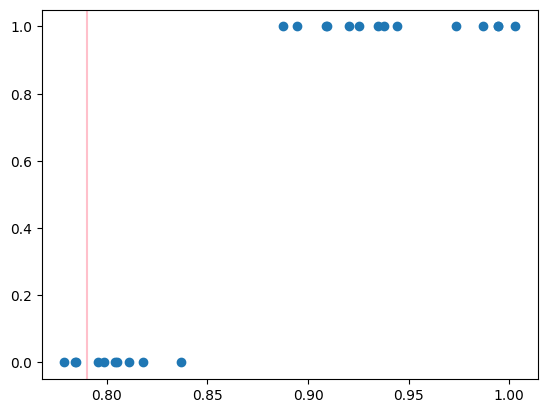

In [29]:
plt.scatter(test_preds,dds['test']['label'])
plt.axvline(x=0.79, color='pink')

Let's use the cutoff point of 0.73 and see how this performs for our evaluation datset.

In [30]:
eval_ds = Dataset.from_pandas(eval_df).map(tok_func, batched=True)
eval_labels = eval_ds['label']
eval_ds = eval_ds.remove_columns('label')

  0%|          | 0/1 [00:00<?, ?ba/s]

In [31]:
preds = trainer.predict(eval_ds).predictions.astype(float)
preds

array([[0.82275391],
       [0.92871094],
       [0.95556641],
       [0.91650391],
       [0.78466797],
       [0.89111328],
       [0.94775391],
       [0.78857422],
       [0.95458984],
       [0.80126953],
       [0.86425781],
       [0.90039062],
       [0.90283203],
       [0.83251953],
       [0.95996094],
       [0.95019531],
       [0.99707031],
       [0.90185547],
       [0.90869141],
       [0.91357422],
       [0.94287109],
       [0.90722656],
       [1.02441406],
       [0.95556641]])

We see that our cutoff point splits the data nicely:

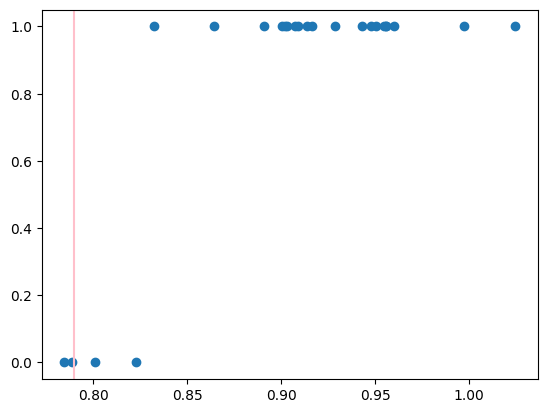

In [32]:
plt.scatter(preds,eval_labels)
plt.axvline(x=0.79, color='pink')

Let's try find the speech that was incorrectly identified

In [33]:
misclassified_indices = []
for i in range(0, 24):
    if (preds[i][0] < 0.79 and eval_labels[i] > 0.5):
        misclassified_indices.append(i)
        print('misclassified at index: ', i)

In [34]:
for i in misclassified_indices:
    print('######')
    print(eval_ds[i]['text'])

## Result
The cutoff point performs just as well for the evaluation dataset.
<br/>
We could use this cutoff point to covert the output values to binary values.
<br/>
We could also perform a logistic regression on our model outputs.
<br/>
It's very important to remember that our model has been optimised to produce a high correlation score.
That is why the model predictions are not very meaningful without applying an additional function at the end.
In a real world example we would very likely choose another method, but as the purpose of this experiment was to show the importance of pre-processing the data, I think it's unnecessary.